## Compare GegenbauerKAN's ability in function interpolation with MLP (Multi-variable)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from GegenbauerKANLayer import GegenbauerKANLayer

In [2]:
# Define the fractal-like 2D function
def fractal_function(x, y):
    z = np.sin(10 * np.pi * x) * np.cos(10 * np.pi * y) + np.sin(np.pi * (x**2 + y**2))
    z += np.abs(x - y) + (np.sin(5 * x * y) / (0.1 + np.abs(x + y)))
    z *= np.exp(-0.1 * (x**2 + y**2))
    
    # Add noise to z
    noise = np.random.normal(0, 0.1, z.shape)
    z += noise
    
    return z

In [3]:
alpha_ = 3
# Define MLP and LegendreKAN
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    
    def forward(self, x):
        return self.layers(x)
        
# Define the GegenbauerKAN model
class GegenbauerKAN(nn.Module):
    def __init__(self):
        super(GegenbauerKAN, self).__init__()
        # Instantiate layers of GegenbauerKANLayer with the correct dimensions
        self.gegenbauerkan1 = GegenbauerKANLayer(2, 8, 8, alpha_)
        self.gegenbauerkan2 = GegenbauerKANLayer(8, 16, 4, alpha_)
        self.gegenbauerkan3 = GegenbauerKANLayer(16, 1, 4, alpha_)

    def forward(self, x):
        # Ensure the outputs of one layer are inputs to the next
        x = self.gegenbauerkan1(x)
        x = self.gegenbauerkan2(x)
        x = self.gegenbauerkan3(x)
        return x


Epoch 1/2000, MLP Loss: 1.0569, GegenbauerKAN Loss: 9.2749
Epoch 101/2000, MLP Loss: 0.4589, GegenbauerKAN Loss: 0.6608
Epoch 201/2000, MLP Loss: 0.3924, GegenbauerKAN Loss: 0.6088
Epoch 301/2000, MLP Loss: 0.3537, GegenbauerKAN Loss: 0.6024
Epoch 401/2000, MLP Loss: 0.3072, GegenbauerKAN Loss: 0.5982
Epoch 501/2000, MLP Loss: 0.2856, GegenbauerKAN Loss: 0.5928
Epoch 601/2000, MLP Loss: 0.2759, GegenbauerKAN Loss: 0.5852
Epoch 701/2000, MLP Loss: 0.2610, GegenbauerKAN Loss: 0.5816
Epoch 801/2000, MLP Loss: 0.2858, GegenbauerKAN Loss: 0.5801
Epoch 901/2000, MLP Loss: 0.2412, GegenbauerKAN Loss: 0.5785
Epoch 1001/2000, MLP Loss: 0.2372, GegenbauerKAN Loss: 0.5771
Epoch 1101/2000, MLP Loss: 0.2641, GegenbauerKAN Loss: 0.5752
Epoch 1201/2000, MLP Loss: 0.2357, GegenbauerKAN Loss: 0.5753
Epoch 1301/2000, MLP Loss: 0.2240, GegenbauerKAN Loss: 4.4061
Epoch 1401/2000, MLP Loss: 0.2190, GegenbauerKAN Loss: 0.5514
Epoch 1501/2000, MLP Loss: 0.2187, GegenbauerKAN Loss: 0.5063
Epoch 1601/2000, MLP

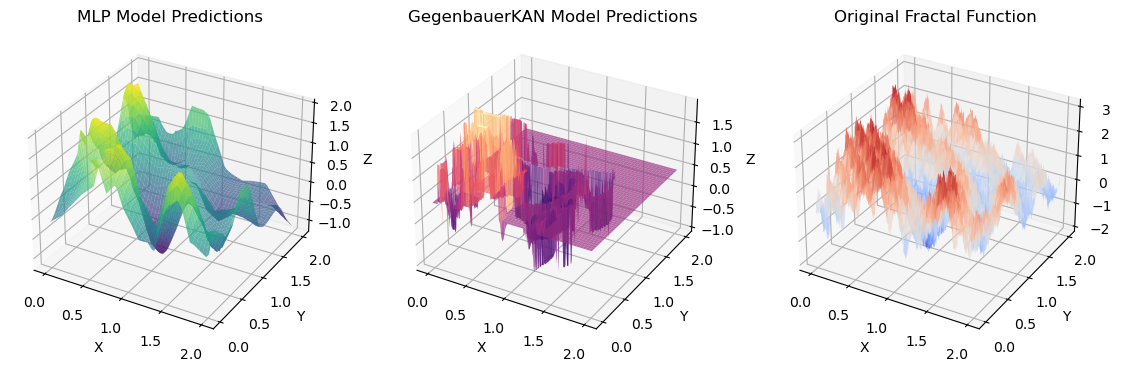

In [4]:
torch.autograd.set_detect_anomaly(True)

# Generate 2D sample data
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
Z = fractal_function(X, Y)
x_train_2d = torch.tensor(np.stack([X.ravel(), Y.ravel()], axis=1), dtype=torch.float32)
y_train_2d = torch.tensor(Z.ravel(), dtype=torch.float32).unsqueeze(1)

# Instantiate the models
mlp_model = SimpleMLP()  
Gegenbauer_model = GegenbauerKAN()

# Define loss functions and optimizers
criterion = nn.MSELoss()
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=0.01)
optimizer_Gegenbauer = torch.optim.Adam(Gegenbauer_model.parameters(), lr=0.01)

# Train the models
epochs = 2000
for epoch in range(epochs):
    # MLP Training
    optimizer_mlp.zero_grad()
    outputs_mlp = mlp_model(x_train_2d)
    loss_mlp = criterion(outputs_mlp, y_train_2d)
    loss_mlp.backward()
    optimizer_mlp.step()

    # GegenbauerKAN Training
    optimizer_Gegenbauer.zero_grad()
    outputs_Gegenbauer = Gegenbauer_model(x_train_2d)
    loss_Gegenbauer = criterion(outputs_Gegenbauer, y_train_2d)
    loss_Gegenbauer.backward()
    optimizer_Gegenbauer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, MLP Loss: {loss_mlp.item():.4f}, GegenbauerKAN Loss: {loss_Gegenbauer.item():.4f}')

# Test the models
x_test = np.linspace(0, 2, 400)
y_test = np.linspace(0, 2, 400)
X_test, Y_test = np.meshgrid(x_test, y_test)
Z_test = fractal_function(X_test, Y_test)
x_test_2d = torch.tensor(np.stack([X_test.ravel(), Y_test.ravel()], axis=1), dtype=torch.float32)
y_pred_mlp = mlp_model(x_test_2d).detach().numpy()
y_pred_Gegenbauer = Gegenbauer_model(x_test_2d).detach().numpy()

# Plot the results using a 3D plot
fig = plt.figure(figsize=(14, 21))
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X_test, Y_test, y_pred_mlp.reshape(X_test.shape), cmap='viridis', alpha=0.7, label='MLP Prediction')
ax1.set_title('MLP Model Predictions')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X_test, Y_test, y_pred_Gegenbauer.reshape(X_test.shape), cmap='magma', alpha=0.7, label='GegenbauerKAN Prediction')
ax2.set_title('GegenbauerKAN Model Predictions')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X_test, Y_test, Z_test, cmap='coolwarm', alpha=0.7, label='Original Function')
ax3.set_title('Original Fractal Function')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
plt.show()